In [ ]:
# default_exp

# Full Example (WIP)

> Exhibiting the tools contained in this library using data from a collider phenomenology study of $Z'$ particles

In [ ]:
# hide
from nbdev.showdoc import *

## Preparing Data

Informed by the documentation of the `import47data()` function, we can pull in all of the data files we'll need for training and testing from Google Storage.

In [ ]:
filename_sig_masses = ['350G', '500G', '1T', '2T', '4T']
filename_bgs = ['h', '4t', 'noh']

In [ ]:
signal_data = [import47Ddata(f'sig{mass}') for mass in filename_sig_masses]

376004608/376000128 [==============================] - 109s 0us/step


In [ ]:
background_data = [import47Ddata(f'bg{name}') for name in filename_bgs]

376004608/376000128 [==============================] - 108s 0us/step


Next, we can prepare data sets actually equipped for training and testing by first appending labels to our data points (using `label_predictors()`) and then by utilizing `sklearn`'s `train_test_split` method.

In [ ]:
labelled_sig_data = [label_predictors(data, isSig=True) for data in signal_data]
labelled_bg_data = [label_predictors(data, isSig=False, bgType=-(i+1)) for i, data in enumerate(background_data)]

In [ ]:
from sklearn.model_selection import train_test_split
train_test_data = [
    train_test_split(
        np.concatenate([sig_data] + [bg_data[:int(len(sig_data)/3)] for bg_data in labelled_bg_data]), 
        test_size=0.25, random_state=42) 
    for sig_data in labelled_sig_data]

Here, we have created a list `train_test_data` of length $5$ (as we have $5$ sampled $Z'$ masses) where each element is a list of length two containing labelled training data and labelled test data (both with signal for fixed mass and all three background). The slicing with the background data is performed to ensure that the number of signal data points and equals that of the background data points. In particular, we've elected to form our background data with equal amounts of each of the three backgrounds.

In [ ]:
print(f'train_test_data has length {len(train_test_data)}')
print(f'each element of train_test_data has length {len(train_test_data[0])}')
print(f'training data is of length {len(train_test_data[0][0])}',
      f'while testing data is of length {len(train_test_data[0][1])}')

train_test_data has length 5
each element of train_test_data has length 2
training data is of length 1499999 while testing data is of length 500000


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScalers
from sklearn.pipeline import make_pipeline

It's useful for standardize your data (subtract the mean and divide by the standard deviation in each feature) before training: we can achieve this through `sklearn`'s `StandardScaler` filter and its `pipeline` functionality.

### Initializing and Training

We'll now initialize and train a logistic regression model for each of our $5$ data sets using our `bcml_model` object. Note that the `*` syntax unpacks a list, so our training data and testing data for a given $Z'$ mass (which makes up our rows of `train_test_data`) are passed as separate arguments to our class instantiation.

In [ ]:
logreg_m350G_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()), *train_test_data[0])
logreg_m350G_model.fit()

In [ ]:
logreg_m500G_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()), *train_test_data[1])
logreg_m500G_model.fit()

In [ ]:
logreg_m1T_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()), *train_test_data[2])
logreg_m1T_model.fit()

In [ ]:
logreg_m2T_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression()), *train_test_data[3])
logreg_m2T_model.fit()

In [ ]:
# this one takes a little longer to converge, we'll bump up max_iter from 100 to 500
logreg_m4T_model = bcml_model(make_pipeline(StandardScaler(), LogisticRegression(max_iter=500)), *train_test_data[4])
logreg_m4T_model.fit()

### Naive Performance Evaluation

Now we can investigate our models' performances. Perhaps we can start by looking at the signal significance they achieve by default, given integrated luminosity $\mathcal{L} = 3000$ fb$^{-1}$. To do this, we're going to need signal and background yield, which we can compute using the function `get_elijah_ttbarzp_cs`, which can pull in our information regarding sampled $Z'$ masses, their associated cross sections, and the background cross sections.

In [ ]:
masses, sig_css, bg_css = get_elijah_ttbarzp_cs()
print(masses)

[10, 50, 100, 200, 350, 500, 1000, 2000, 5000]


We will need a signal cross section for $m_{Z'} = 4000$ GeV, which we don't have, so we shall take a quick detour to interpolate it using our `cross_section_helper` object. In doing so, we'll update `masses` and `sig_css` to more relevant values.

In [ ]:
zp_cs = cross_section_helper(masses, sig_css, bg_css, mass_units='GeV')
masses = [350, 500, 1000, 2000, 4000]
sig_css = [zp_cs.sig_cs(mass) for mass in masses]

In [ ]:
conv = 10**15 / 10**12 # conv * lumi (in fb^{-1}) * cross sec (in pb) = # of events
lumi = 3000
signal_yields = [conv * lumi * sig_cs for sig_cs in sig_css]
background_yield = sum([conv * lumi * bg_cs for bg_cs in bg_css])

In [ ]:
models = [logreg_m350G_model, logreg_m500G_model, logreg_m1T_model, logreg_m2T_model, logreg_m4T_model]

In [ ]:
logreg_m350G_model = refresh_model(logreg_m350G_model)
logreg_m500G_model = refresh_model(logreg_m500G_model)
logreg_m1T_model = refresh_model(logreg_m1T_model)
logreg_m2T_model = refresh_model(logreg_m2T_model)
logreg_m4T_model = refresh_model(logreg_m4T_model)

In [ ]:
for model, mass, signal_yield in zip(models, masses, signal_yields):
    significance = model.significance(signal_yield, background_yield, sepbg=True)
    print(f"For Z' mass = {mass} GeV, logistic regression gives a signal significance of {round(significance, 3)} sigma")

For Z' mass = 350 GeV, logistic regression gives a signal significance of 9.276 sigma
For Z' mass = 500 GeV, logistic regression gives a signal significance of 4.853 sigma
For Z' mass = 1000 GeV, logistic regression gives a signal significance of 1.184 sigma
For Z' mass = 2000 GeV, logistic regression gives a signal significance of 0.163 sigma
For Z' mass = 4000 GeV, logistic regression gives a signal significance of 0.003 sigma


Notice that what we have is a set of models parameterized by a number, the $Z'$ mass: this makes the `multi_model` class relevant to us.

In [ ]:
logreg_models = multi_model(models, masses)

In particular, we can get a nice visualization of signal vs $Z'$ mass, with some help from `matplotlib.pyplot` settings retrievable via `get_settings()`

In [ ]:
sample_masses = np.linspace(masses[0], masses[-1], 500)
max_mass = zp_cs.absolute_max_mass_sens()
f = logreg_models.index2logsigF(signal_yields, background_yield)

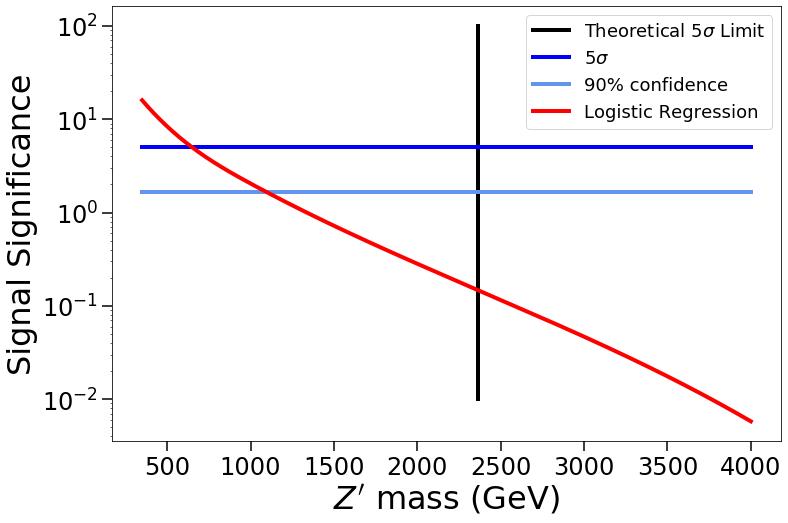

In [ ]:
import matplotlib.pyplot as plt

with plt.rc_context(get_settings()):
    plt.plot([max_mass for i in range(2)], np.logspace(-2, 2, 2), label=r'Theoretical $5\sigma$ Limit', c='black')
    plt.plot(sample_masses, [5 for m in sample_masses], label=r'5$\sigma$', c='blue')
    plt.plot(sample_masses, [1.645 for m in sample_masses], label=r'90% confidence', c='cornflowerblue')
    plt.plot(
        sample_masses, [10**f(m) for m in sample_masses], label='Logistic Regression', c='red')
    plt.ylabel('Signal Significance');
    plt.xlabel(r"$Z'$ mass (GeV)");
    plt.yscale('log')
    plt.legend()

# More Sophisticated Evaluation: Threshold Optimization

When passed a data point, a trained `bcml_model` assigns a signal probability. By default, an `sk-learn` (and thus, our `bcml_model`) model predicts that the datapoint is signal if the associated signal probability is greater than $0.5$. However, $0.5$ need not be the optimal threshold: for this purpose, we provide the ability to optimize this threshold on a test data set. Let's see how this boosts our logistic regression models' performance.

In [ ]:
for model, mass, signal_yield in zip(models, masses, signal_yields):
    output = model.best_threshold(signal_yield, background_yield, sepbg=True)
    significance = output[1]
    print(
        f"For Z' mass = {mass} GeV, logistic regression gives an optimized signal significance \
        of {round(significance, 3)} sigma")

For Z' mass = 350 GeV, logistic regression gives an optimized signal significance of 10.188 sigma
For Z' mass = 500 GeV, logistic regression gives an optimized signal significance of 5.888 sigma
For Z' mass = 1000 GeV, logistic regression gives an optimized signal significance of 2.083 sigma
For Z' mass = 2000 GeV, logistic regression gives an optimized signal significance of 2.767 sigma
For Z' mass = 4000 GeV, logistic regression gives an optimized signal significance of 1.011 sigma


Now we can overlay our new optimized signal significances onto our old plot using a settings on the `index2logsigF` function.

In [ ]:
opt_f = logreg_models.index2logsigF(signal_yields, background_yield, opt=True, sepbg=True)

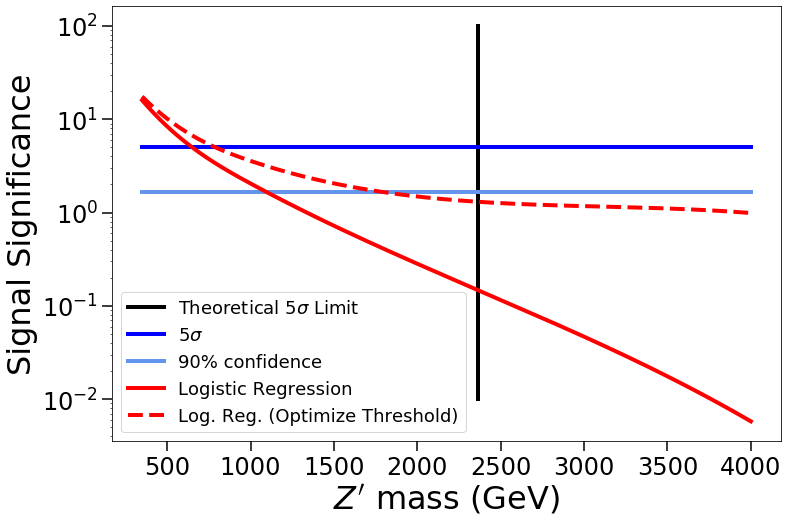

In [ ]:
import matplotlib.pyplot as plt

with plt.rc_context(get_settings()):
    plt.plot([max_mass for i in range(2)], np.logspace(-2, 2, 2), label=r'Theoretical $5\sigma$ Limit', c='black')
    plt.plot(sample_masses, [5 for m in sample_masses], label=r'5$\sigma$', c='blue')
    plt.plot(sample_masses, [1.645 for m in sample_masses], label=r'90% confidence', c='cornflowerblue')
    plt.plot(
        sample_masses, [10**f(m) for m in sample_masses], label='Logistic Regression', c='red')
    plt.plot(
        sample_masses, [10**opt_f(m) for m in sample_masses], label='Log. Reg. (Optimize Threshold)', c='red', linestyle='--')
    plt.ylabel('Signal Significance');
    plt.xlabel(r"$Z'$ mass (GeV)");
    plt.yscale('log')
    plt.legend()